# 1. Setup

#### 1.1 Installing Dependencies

In [2]:
!pip install tensorflow opencv-python matplotlib


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: D:\PyCharm 2022.2.2\Py3_10_7\python.exe -m pip install --upgrade pip


#### 1.2 Import Dependencies

In [9]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [10]:
# import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

#### 1.3 Set GPU Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumpyion Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
for gpu in gpus:
    print(gpu)

#### 1.4 Create Folder Structures

In [11]:
# Setup paths
POS_PATH = os.path.join('D:/TheCodes/Upgrad_Projects/Y4S1/Project/data', 'positive')
NEG_PATH = os.path.join('D:/TheCodes/Upgrad_Projects/Y4S1/Project/data', 'negative')
ANC_PATH = os.path.join('D:/TheCodes/Upgrad_Projects/Y4S1/Project/data', 'anchor')

In [9]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

#### 2.1 Untar Labelled Faces in the Wild Dataset

In [15]:
# http://vis-www.cs.umass.edu/lfw/

In [12]:
# Uncompress TarGZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [13]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)


#### 2.2 Collect Positives and Anchor Classes

In [6]:
# Import uuid library to generate unique image names
import uuid

In [8]:
# Establish connection to webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # cut down frame to 250x250 px
    frame = frame[200:200+250, 200:200+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect Positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
       # Create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)

    cv2.imshow('Image Collection', frame)

    if cv2.waitKey(1) & 0XFF == ord('q'):
       break

cap.release()
cv2.destroyAllWindows()

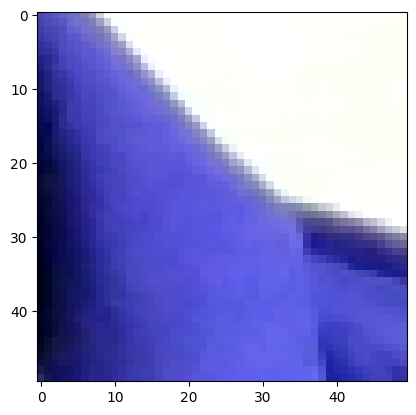

In [9]:
plt.imshow(frame[200:200+250, 200:200+250, :])

# 3. Load and Preprocess Images

#### 3.1 Get Image Directories

In [12]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(300)

In [13]:
dir_test = anchor.as_numpy_iterator()

In [14]:
dir_test.next()

b'D:\\TheCodes\\Upgrad_Projects\\Y4S1\\Project\\data\\anchor\\047128a1-7255-11ee-83a8-089798b95db6.jpg'

#### 3.2 Preprocessing - Scale and Resize

In [15]:
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [18]:
img = preprocess('D:\\TheCodes\\Upgrad_Projects\\Y4S1\\Project\\data\\anchor\\047128a1-7255-11ee-83a8-089798b95db6.jpg')

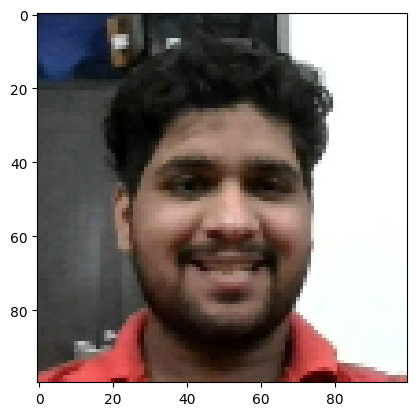

In [20]:
plt.imshow(img)

In [ ]:
dataset.map(preprocess)

#### 3.3 Create Labelled Dataset

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [21]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [22]:
samples = data.as_numpy_iterator()

In [23]:
exampple = samples.next()

In [24]:
exampple

(b'D:\\TheCodes\\Upgrad_Projects\\Y4S1\\Project\\data\\anchor\\0ffd0076-7255-11ee-8ba0-089798b95db6.jpg',
 b'D:\\TheCodes\\Upgrad_Projects\\Y4S1\\Project\\data\\positive\\3c252fa1-7255-11ee-b44e-089798b95db6.jpg',
 1.0)

#### 3.4 Build Train and Test Partition

In [25]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [26]:
res = preprocess_twin(*exampple)

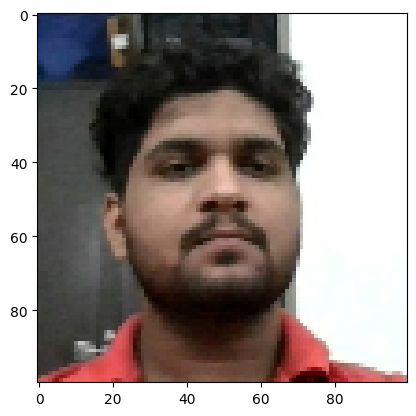

In [28]:
plt.imshow(res[0])

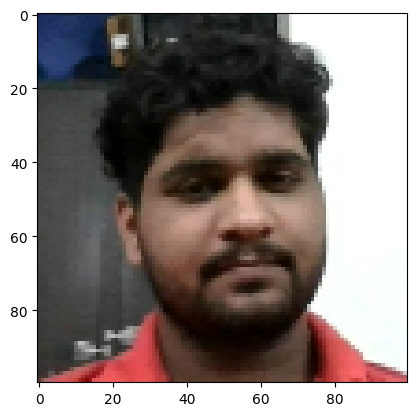

In [27]:
plt.imshow(res[1])

In [29]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [30]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [31]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering
<img src="Screenshot 2023-10-24 195654.png">

#### 4.1 Build Embedding Layer

In [32]:
inp = Input(shape=(100,100,3), name='input_image')
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [33]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [34]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [35]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [36]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [37]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [38]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [39]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [40]:
embedding = make_embedding()

In [41]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

#### 4.2 Build Distance Layer

In [42]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [43]:
l1 = L1Dist()

In [44]:
l1(anchor_embedding, validation_embedding)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "D:\PyCharm 2022.2.2\Py3_10_7\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\aryan\AppData\Local\Temp\ipykernel_15128\1240249918.py", line 1, in <module>
    l1(anchor_embedding, validation_embedding)
NameError: name 'anchor_embedding' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\PyCharm 2022.2.2\Py3_10_7\lib\site-packages\IPython\core\interactiveshell.py", line 2052, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "D:\PyCharm 2022.2.2\Py3_10_7\lib\site-packages\IPython\core\ultratb.py", line 1112, in structured_traceback
    return FormattedTB.structured_traceback(
  File "D:\PyCharm 2022.2.2\Py3_10_7\lib\site-packages\IPython\core\ultratb.py", line 1006, in structured_traceback
    return VerboseTB.structured_traceback(
  File "D:\Py

#### 4.3 Make Siamese Model

In [45]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [46]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [47]:
siamese_layer = L1Dist()

In [48]:
distances = siamese_layer(inp_embedding, val_embedding)

In [49]:
classifier = Dense(1, activation='sigmoid')(distances)

In [50]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [51]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [52]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [53]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [54]:
siamese_model = make_siamese_model()

In [55]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# 5. Training

#### 5.1 Setup Loss and Optimizer

In [56]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [57]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

#### 5.2 Establish Checkpoints

In [58]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

#### 5.3 Build Train Step Function

In [59]:
test_batch = train_data.as_numpy_iterator()

In [60]:
batch_1 = test_batch.next()

In [61]:
X = batch_1[:2]

In [62]:
y = batch_1[2]

In [63]:
y

array([1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

In [64]:
tf.losses.BinaryCrossentropy??

In [65]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

#### 5.4 Build Training Loop

In [66]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [67]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

#### 5.5 Train the model

In [68]:
EPOCHS = 50

In [69]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 470s 17s/step
0.2390135 0.68372095 1.0

 Epoch 2/50
27/27 [==============================] - 453s 17s/step
0.11708326 0.9705882 0.99497485

 Epoch 3/50
12/27 [============>.................] - ETA: 4:16Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "D:\PyCharm 2022.2.2\Py3_10_7\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\aryan\AppData\Local\Temp\ipykernel_15128\391551703.py", line 1, in <module>
    train(train_data, EPOCHS)
  File "C:\Users\aryan\AppData\Local\Temp\ipykernel_15128\2404419015.py", line 14, in train
    loss = train_step(batch)
  File "D:\PyCharm 2022.2.2\Py3_10_7\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "D:\PyCharm 2022.2.2\Py3_10_7\lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py", line 825, in __call__
    result = self._call(*args, **kwds)
  File "D:\PyCharm 2022.2.2\Py3_10_7\lib\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py", line 857, in _call
    return self._no_variable_creation_fn(*args, **kwds)  # pylint